### IMDB Data for use with an Embedding layer 

In [2]:
# Import imdb dataset and preprocessing module to be used for processing data in the format required for Neural Networks 
# Examples of preprocessing includes 1) padding extra zeros at the end 
# 
from keras.datasets import imdb 
from keras import preprocessing 

max_features = 10000 
maxlen = 20 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [5]:
# Using an Embedding layer and classifier on the IMDB data 

from keras.layers import Embedding 
from keras.models import Sequential 
from keras.layers import Flatten, Dense 

model = Sequential()
model.add(Embedding(10000,8, input_length=maxlen))
model.add(Flatten()) # Flattens a 3D tensor of embeddings into a 2D tensor of share (Samples, maxlen *8)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train, 
                   epochs=10, 
                   batch_size=32, 
                   validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 173us/step - loss: 0.6705 - acc: 0.6195 - val_loss: 0.6197 - val_acc: 0.6962
Epoch 2/10
20000/20000 [==============================] - 2s 101us/step - loss: 0.5419 - acc: 0.7520 - val_loss: 0.5259 - val_acc: 0.7270
Epoch 3/10
20000/20000 [==============================

In [33]:
# This function reads a Excel file and prepares data in the format: 
# 
import os, xlrd, re 
import nltk
from nltk.tokenize import sent_tokenize
def preprocessText(text, row):
    text = re.sub(r'[?|$|.|!"(-),]',r'',text)
    tokens = re.split(r'[`\-=~!@#$%^&*()_\[\]{};\'\\:"|<,/<>?\s]', text) 
    #tokens = text.split()
    features = []
    #for text in sent_tokenize(text): 
    for word in tokens:
        if word.lower() not in stop_words and len(word) > 2:
            features.append(word.lower())
    features = ' '.join(features)
    return features

def readReviews(fileName):
    book = xlrd.open_workbook(fileName)
    sheet = book.sheet_by_index(2) 
    texts = []
    labels = []
    yesComparisons = 0 
    nonComparisons = 0 
    for row in range(1,sheet.nrows):
        comparisonType = int(sheet.row_values(row)[12])
        reviewText = sheet.row_values(row)[1]
        if type(reviewText) == str: 
            pass 
        else: 
            continue 
        if comparisonType == 0 and len(reviewText) > 100: 
            nonComparisons += 1 
            if nonComparisons < 3000: 
                text = preprocessText(reviewText, row)
                texts.append(text)
                labels.append(comparisonType)
        if comparisonType == 1 and len(reviewText) > 100: 
            yesComparisons += 1 
            if yesComparisons < 2600: 
                text = preprocessText(reviewText, row)
                texts.append(text)
                labels.append(comparisonType)
        if yesComparisons > 2900 and nonComparisons > 2599: 
            break 
    return texts, labels 
global stop_words 
stop_words = nltk.corpus.stopwords.words('english')
fileName = os.getcwd() + "\\Input\\labelledReviews.xlsx"
texts, labels = readReviews(fileName)
print(len(texts), len(labels))

5598 5598


In [34]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np 

maxlen = 100 
training_samples = 200 
validation_samples = 2000 
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index 
print('Found %s unique tokens.' %len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('shape of data tensor: ', data.shape)
print('shape of label tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 11832 unique tokens.
shape of data tensor:  (5598, 100)
shape of label tensor:  (5598,)


In [36]:
glove_embeddings_file = os.getcwd() + "\\Input\\glove.6B.100d.txt"
embeddings_index = {}
fileCursor = open(glove_embeddings_file, encoding="utf8")
for line in fileCursor: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
fileCursor.close()

print('Found %s word vector.' %len(embeddings_index))

Found 400000 word vector.


In [48]:
embedding_dim = 100 
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector 

In [49]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [50]:
# The Neural Networks code with the preloaded embeddings take the pretrained weights, which are already 
# loaded into embedding_matrix
# model.layers[0].set_weights([embedding_matrix]) # Uncomment these lines to use the pretrained embeddings Neural weights  
# model.layers[0].trainable = False  # Uncomment this line to compute the neural weights 

model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['acc'])
history = model.fit(x_train, y_train, 
                   epochs=10, 
                   batch_size=32, 
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_model.h5')

Train on 200 samples, validate on 2000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6574 - acc: 0.6000 - val_loss: 0.6265 - val_acc: 0.7045
Epoch 2/10
200/200 [==============================] - 0s 778us/step - loss: 0.5412 - acc: 0.7600 - val_loss: 0.6404 - val_acc: 0.6700
Epoch 3/10
200/200 [==============================] - 0s 753us/step - loss: 0.4165 - acc: 0.8500 - val_loss: 0.5659 - val_acc: 0.7070
Epoch 4/10
200/200 [==============================] - 0s 778us/step - loss: 0.3080 - acc: 0.9450 - val_loss: 0.5705 - val_acc: 0.7285
Epoch 5/10
200/200 [==============================] - 0s 773us/step - loss: 0.2053 - acc: 0.9650 - val_loss: 0.5678 - val_acc: 0.7330
Epoch 6/10
200/200 [==============================] - 0s 728us/step - loss: 0.1318 - acc: 0.9700 - val_loss: 0.7115 - val_acc: 0.6700
Epoch 7/10
200/200 [==============================] - 0s 698us/step - loss: 0.1086 - acc: 0.9700 - val_loss: 0.5545 - val_acc: 0.7235
Epoch 8/10
200/20

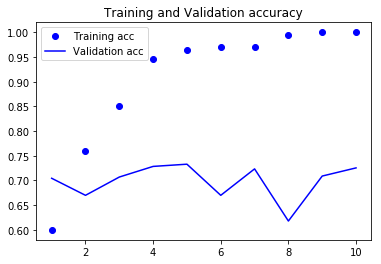

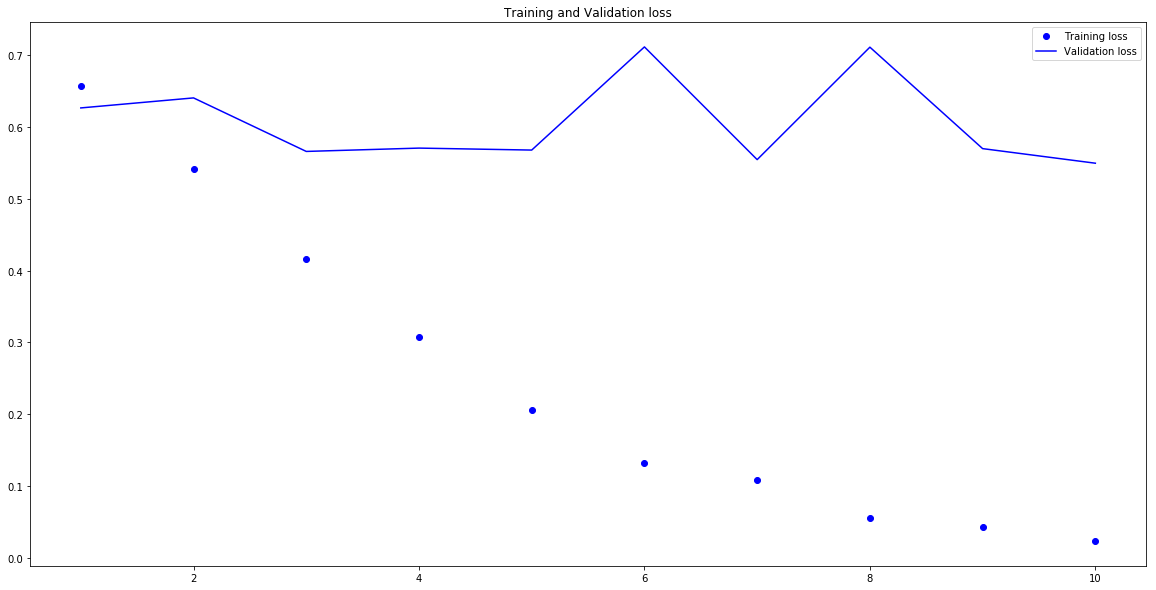

In [51]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure(figsize=(20, 10))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()